In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap


/home/guests3/gba/.conda/envs/tese-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# 🚀 Load raw read count CSV
readcount_df = pd.read_csv("../../data/original/rnaseq_read_count.csv", index_col=0)

# 📋 Drop the gene name column (second column)
readcount_df_clean = readcount_df.drop(readcount_df.columns[0], axis=1)

# Transpose to get cell lines as rows, genes as columns
readcount_transposed = readcount_df_clean.transpose()

# Rename index to 'SIDM'
readcount_transposed.index.name = "SIDM"
readcount_transposed.reset_index(inplace=True)

print("✅ Transposed bulk RNA-seq data:")
print(readcount_transposed.iloc[:5, :5])


/tmp/ipykernel_3837146/3606837027.py:2: DtypeWarning: Columns (1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121,1122,1123,1342,1343,1344,1345,1346,1347,1348,1349,1350,1351,1352,1353,1354,1355,1356,1357,1358,1359,1360,1361,1362,1363,1364,1365,1366,1367,1368,1369,1370,1371,1372,1373,1374,1375,1376,1377,1378,1379,1380,1381,1382,1383,1384,1385,1386,1387,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432) have mixed types. Specify dtype option on import or set low_memory=False.
  readcount_df = pd.read_csv("../../data/original/rnaseq_read_count.csv", index_col=0)


✅ Transposed bulk RNA-seq data:
SANGER_MODEL_ID       SIDM SIDG00001 SIDG00002 SIDG00003 SIDG00004
0                SIDM00001      37.0     121.0       3.0      38.0
1                SIDM00002     152.0     799.0       0.0     230.0
2                SIDM00003     124.0    2038.0       0.0   11771.0
3                SIDM00005     149.0     244.0       1.0      64.0
4                SIDM00006     121.0    1167.0      11.0   30467.0


In [6]:
# Convert all gene columns to numeric, forcing errors to NaN
readcount_transposed_numeric = readcount_transposed.iloc[:, 1:].apply(
    pd.to_numeric,
    errors='coerce'
)

# Compute total read counts per cell line
readcount_transposed["total_read_count"] = readcount_transposed_numeric.sum(axis=1)

# Sort for visualization if needed
readcount_transposed_sorted = readcount_transposed.sort_values(by="total_read_count", ascending=False)

# Preview
print("✅ Total read counts computed successfully:")
print(readcount_transposed_sorted[["SIDM", "total_read_count"]].head())


✅ Total read counts computed successfully:
SANGER_MODEL_ID       SIDM  total_read_count
161              SIDM00200       556241031.0
62               SIDM00094       462383179.0
148              SIDM00187       436777556.0
187              SIDM00231       433774879.0
843              SIDM00974       426994185.0


In [ ]:
# Extract gene count columns safely
X_counts_df = readcount_transposed.iloc[:, 1:-1].apply(pd.to_numeric, errors='coerce')
X_counts = X_counts_df.to_numpy(dtype=np.float64)

# Log1p transform
X_log = np.log1p(X_counts)

# Standardize
X_scaled = StandardScaler().fit_transform(X_log)

# Fill NaNs with zeros
X_scaled_no_nan = np.nan_to_num(X_scaled, nan=0.0)

# Compute PCA
pca = PCA(n_components=30, random_state=42)
X_pca = pca.fit_transform(X_scaled_no_nan)

# Explained variance
explained_var = np.cumsum(pca.explained_variance_ratio_)
print(f"✅ PCA completed. Variance explained by first 30 PCs: {explained_var[-1]:.2%}")

✅ PCA completed. Variance explained by first 30 PCs: 49.02%


In [10]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_coords = tsne.fit_transform(X_pca)

# Add to DataFrame
readcount_transposed["TSNE_1"] = tsne_coords[:, 0]
readcount_transposed["TSNE_2"] = tsne_coords[:, 1]

print("✅ t-SNE computed and added to DataFrame.")


✅ t-SNE computed and added to DataFrame.


In [11]:
umap_reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
umap_coords = umap_reducer.fit_transform(X_pca)

readcount_transposed["UMAP_1"] = umap_coords[:, 0]
readcount_transposed["UMAP_2"] = umap_coords[:, 1]

print("✅ UMAP computed and added to DataFrame.")


/home/guests3/gba/.conda/envs/tese-env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ UMAP computed and added to DataFrame.


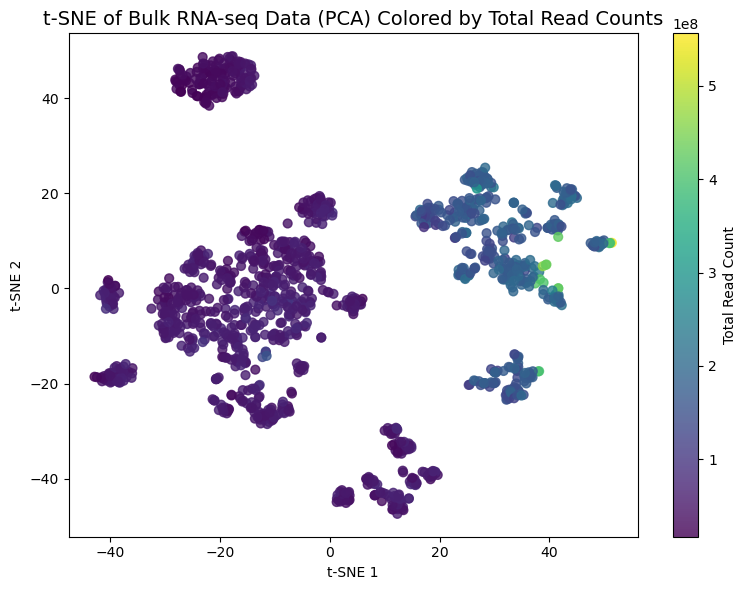

In [14]:
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    readcount_transposed["TSNE_1"],
    readcount_transposed["TSNE_2"],
    c=readcount_transposed["total_read_count"],
    cmap="viridis",
    s=40,
    alpha=0.8
)
plt.colorbar(sc, label="Total Read Count")
plt.title("t-SNE of Bulk RNA-seq Data (PCA) Colored by Total Read Counts", fontsize=14)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


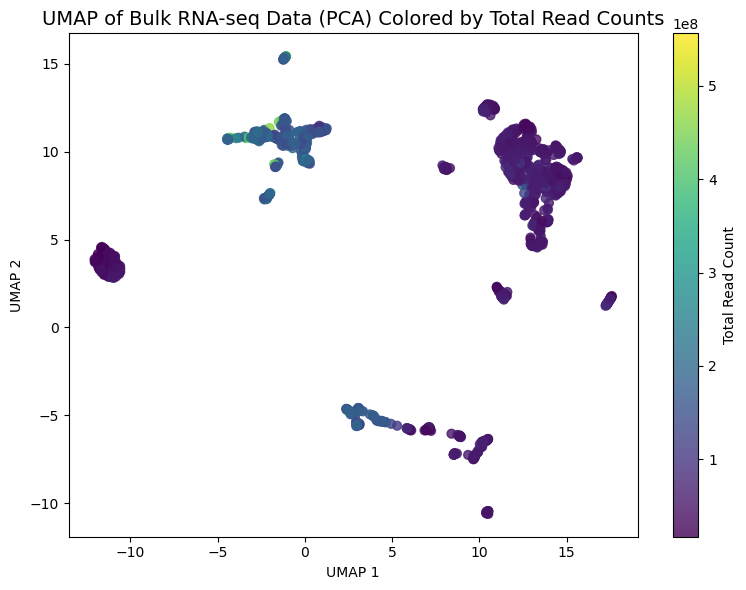

In [15]:
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    readcount_transposed["UMAP_1"],
    readcount_transposed["UMAP_2"],
    c=readcount_transposed["total_read_count"],
    cmap="viridis",
    s=40,
    alpha=0.8
)
plt.colorbar(sc, label="Total Read Count")
plt.title("UMAP of Bulk RNA-seq Data (PCA) Colored by Total Read Counts", fontsize=14)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()
